https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1
https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb
https://nandhini-aitec.medium.com/day-22-anomaly-detection-histogram-based-outlier-score-pyod-pycaret-85c485bc0a3

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.8 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=dd6d48d3f21c7df4b59bec38ed71f3bda4602ef6d72b6f428965e519e535b1af
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [ ]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=76f9af63a98ee0be8d1624f58fcc96d745c4c9bc1e250a7290e0b2e90085dbb2
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

### Import the dataset

In [ ]:
df = pd.read_excel('/content/gdrive/My Drive/Udemy courses/Proper for recording/Store.xls')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



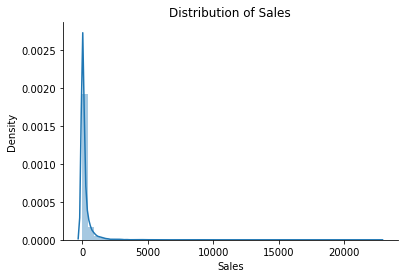

In [ ]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

**The Superstore’s sales distribution is far from a normal distribution, and it has a positive long thin tail**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



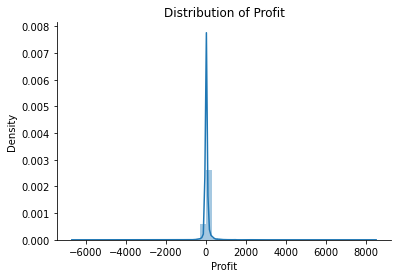

In [ ]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

**The Superstore’s Profit distribution has both a positive tail and negative tail. However, the positive tail is longer than the negative tail. So the distribution is positive skewed**

#### Univariate anomaly detection

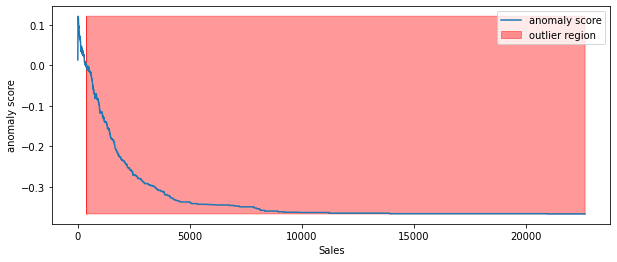

In [ ]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
result = df.copy()
result['Anomaly'] = outlier
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

**decision_function :  The anomaly score of the input samples. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers**

**According to the above results and visualization, It seems that Sales that exceeds 2500 would be definitely considered as an outlier.**

In [ ]:
result[result['Anomaly']==-1].iloc[78]

Row ID                                               245
Order ID                                  CA-2014-131926
Order Date                           2014-06-01 00:00:00
Ship Date                            2014-06-06 00:00:00
Ship Mode                                   Second Class
Customer ID                                     DW-13480
Customer Name                              Dianna Wilson
Segment                                      Home Office
Country                                    United States
City                                           Lakeville
State                                          Minnesota
Postal Code                                        55044
Region                                           Central
Product ID                               FUR-CH-10004063
Category                                       Furniture
Sub-Category                                      Chairs
Product Name     Global Deluxe High-Back Manager's Chair
Sales                          

In [ ]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

### Building isolation forest model on Profit

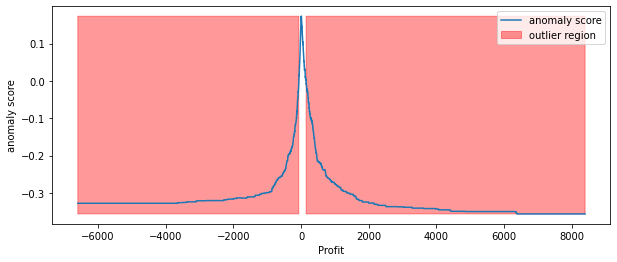

In [ ]:

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
result = df.copy()
result['Anomaly'] = outlier
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

In [ ]:
result[result['Anomaly']==-1].iloc[1]

Row ID                                                           2
Order ID                                            CA-2016-152156
Order Date                                     2016-11-08 00:00:00
Ship Date                                      2016-11-11 00:00:00
Ship Mode                                             Second Class
Customer ID                                               CG-12520
Customer Name                                          Claire Gute
Segment                                                   Consumer
Country                                              United States
City                                                     Henderson
State                                                     Kentucky
Postal Code                                                  42420
Region                                                       South
Product ID                                         FUR-CH-10000454
Category                                                 Furni

In [ ]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

The above two visualizations show the anomaly scores and highlighted the regions where the outliers are.As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.
However, Univariate analysis can only get us thus far. We may realize that some of these anomalies that determined by our models are not the anomalies we expected. When our data is multidimensional as opposed to univariate, the approaches to anomaly detection become more computationally intensive and more mathematically complex.

#### **Multivariate Anomaly Detection**

**Using the Sales and Profit variables, we are going to build an unsupervised multivariate anomaly detection method based on several models.**

**When we are in business, we expect that Sales & Profit are positive correlated. If some of the Sales data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further investigated.**

In [ ]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


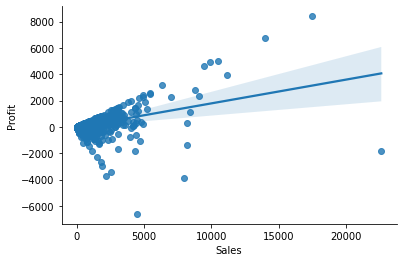

In [ ]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values.

### **Cluster-based Local Outlier Factor**

* Here outlier score is calculated based on cluster-based local outlier factor.
* It classifies the clusters into small clusters and large clusters 
*  The anomaly score is then calculated based on the size of the cluster the point belongs to as well as the distance to the nearest large cluster.


* **n_clusters** (int, optional (default=8)) – The number of clusters to form
* **contamination** (float in (0., 0.5), optional (default=0.1)) – The amount of contamination of the data set, i.e. the proportion of outliers in the data set
* **clustering_estimator** - The base clustering algorithm for performing data clustering.If not set, CBLOF uses KMeans for scalability
* **decision_function(X)** - Predict raw anomaly score of X using the fitted detector.
* **fit(X)** - Fit detector
* **fit_predict(X)** -Fit detector first and then predict whether a particular sample is outlier or inlier
* **Predict** if a particular sample is an outlier or not.

In [ ]:
cols = ['Sales', 'Profit']
##Scaling Sales and Profit to between zero and one.
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [ ]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

## **Source : https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/**

OUTLIERS: 100 INLIERS: 9894


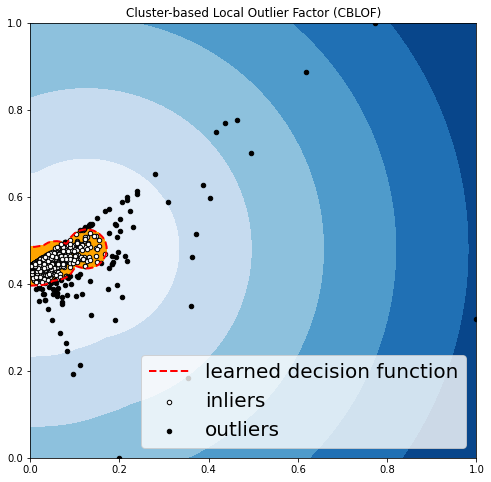

In [ ]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=0.01,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();